In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train_X = train.iloc[:,1:]
train_y = train['label']

print(train_X.shape)
print(train_y.shape)
print(test.shape)

del train 

(42000, 784)
(42000,)
(28000, 784)


In [3]:
train_y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [4]:
train_X.isnull().sum().sum()

0

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# Normalize the data
train_X = train_X / 255.0
test = test / 255.0

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train_X = train_X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
train_y = to_categorical(train_y, num_classes = 10)

In [9]:
# Split the train and the validation set for the fitting
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.33)


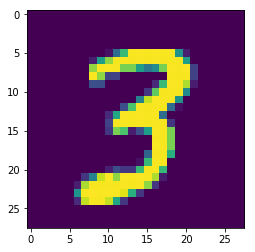

In [10]:
plt.imshow(train_X[0][:,:,0])

In [11]:

model = Sequential()


model.add(Conv2D(filters = 32, kernel_size = (2,2),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation = "softmax"))

opt = Adam(lr=0.012, decay=0.001) # the decay param decreases the learning rate of that amount at each epoch

model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])

In [12]:
epochs = 15

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(train_X)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(train_X, 
                                 train_y, 
                                 batch_size=64),
                    validation_data = (val_X, val_y),
                    epochs=epochs)


Epoch 1/15
440/440 [==============================] - 22s 49ms/step - loss: 0.5291 - categorical_accuracy: 0.8326 - val_loss: 0.1123 - val_categorical_accuracy: 0.9672
Epoch 2/15
440/440 [==============================] - 21s 49ms/step - loss: 0.2286 - categorical_accuracy: 0.9283 - val_loss: 0.1017 - val_categorical_accuracy: 0.9693
Epoch 3/15
440/440 [==============================] - 21s 48ms/step - loss: 0.1778 - categorical_accuracy: 0.9450 - val_loss: 0.0794 - val_categorical_accuracy: 0.9752
Epoch 4/15
440/440 [==============================] - 22s 50ms/step - loss: 0.1594 - categorical_accuracy: 0.9489 - val_loss: 0.0766 - val_categorical_accuracy: 0.9768
Epoch 5/15
440/440 [==============================] - 21s 48ms/step - loss: 0.1417 - categorical_accuracy: 0.9555 - val_loss: 0.0692 - val_categorical_accuracy: 0.9793
Epoch 6/15
440/440 [==============================] - 21s 48ms/step - loss: 0.1317 - categorical_accuracy: 0.9579 - val_loss: 0.0821 - val_categorical_accuracy:

In [13]:
pred_y = model.predict(val_X)
print('RMSE = %.6f' % math.sqrt(mean_squared_error(pred_y, val_y)))


RMSE = 0.047778


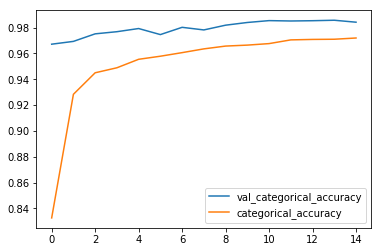

In [14]:
sns.lineplot(x=range(len(history.history['val_categorical_accuracy'])), y=history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
sns.lineplot(x=range(len(history.history['categorical_accuracy'])), y=history.history['categorical_accuracy'], label='categorical_accuracy')


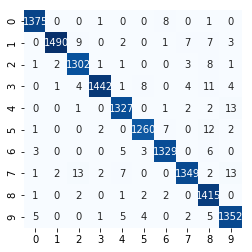

In [15]:
matrix = confusion_matrix(val_y.argmax(axis=1), pred_y.argmax(axis=1))

sns.heatmap(matrix, cbar=False, annot=True, fmt='d', cmap="Blues", square=True)


## Submission

In [16]:
test_y = model.predict(test)
test_y = test_y.round()
out_label = [ np.argmax(i) for i in test_y]
out_imageid = [ i+1 for i in range(len(test_y))]
out = pd.DataFrame()
out['ImageId'] = out_imageid
out['Label'] = out_label

out.to_csv('submission.csv', index=False)
out

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
